<a href="https://colab.research.google.com/github/cannin/gsoc_2023_pytorch_pathway_commons/blob/main/Notebooks/gnn_modelling_with_acc_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=52d8b5a6f54728a5960461084b1acd3c94db7700adf0135aba0fdf09d5de5536
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


# Importing Data and Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)

# if device.type != 'cuda':
#     raise SystemError('GPU device not found')

In [ ]:
!wget https://zenodo.org/record/8286179/files/train_set.zip?download=1 -O train_set.zip

--2023-08-28 11:59:17--  https://zenodo.org/record/8286179/files/train_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1492010 (1.4M) [application/octet-stream]
Saving to: ‘train_set.zip’

train_set.zip       100%[===================>]   1.42M   526KB/s    in 2.8s    

2023-08-28 11:59:21 (526 KB/s) - ‘train_set.zip’ saved [1492010/1492010]



In [ ]:
!wget https://zenodo.org/record/8286179/files/test_set.zip?download=1 -O test_set.zip

--2023-08-28 11:59:22--  https://zenodo.org/record/8286179/files/test_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 780091 (762K) [application/octet-stream]
Saving to: ‘test_set.zip’

test_set.zip        100%[===================>] 761.81K   528KB/s    in 1.4s    

2023-08-28 11:59:25 (528 KB/s) - ‘test_set.zip’ saved [780091/780091]



In [ ]:
!unzip /content/test_set.zip

Archive:  /content/test_set.zip
   creating: test_set/
  inflating: test_set/edge_index.pt  
  inflating: test_set/X_test.csv     
  inflating: test_set/y_test.csv     


In [ ]:
!unzip /content/train_set.zip

Archive:  /content/train_set.zip
   creating: train_set/
  inflating: train_set/edge_index.pt  
  inflating: train_set/X_train.csv   
  inflating: train_set/y_train.csv   


In [ ]:
X_train = pd.read_csv("train_set/X_train.csv", index_col=0)
y_train = np.loadtxt("train_set/y_train.csv", delimiter=',')
X_test = pd.read_csv("test_set/X_test.csv", index_col=0)
y_test = np.loadtxt("test_set/y_test.csv", delimiter=',')

In [ ]:
edge_index = torch.load('train_set/edge_index.pt')

In [ ]:
edge_index

tensor([[   0,    0,    0,  ..., 9287, 9287, 9287],
        [ 451,  452,  453,  ..., 3323, 3340, 3341]])

In [ ]:
X_train.shape, X_test.shape

((54, 9288), (24, 9288))

In [ ]:
X_train = X_train.values
X_test = X_test.values

# Generating patient-specific graphs

In [ ]:
num_patients_train = X_train.shape[0]
num_patients_test = X_test.shape[0]

# Create patient-specific graphs for the training set
graphs_train = []
for i in range(num_patients_train):
    node_features = X_train[i]  # Node features for the i-th patient
    target = y_train[i]  # Target label for the i-th patient
    graph_train = (node_features, edge_index, target)
    graphs_train.append(graph_train)

# Create patient-specific graphs for the test set
graphs_test = []
for i in range(num_patients_test):
    node_features = X_test[i]  # Node features for the i-th patient
    target = y_test[i]  # Target label for the i-th patient
    graph_test = (node_features, edge_index, target)
    graphs_test.append(graph_test)

In [ ]:
# Check the number of patient-specific graphs
print(len(graphs_train))  # Should be 62
print(len(graphs_test))  # Should be 16

54
24


In [ ]:
# Access the patient-specific graph for a specific patient in the training set
patient_index = 0 # Index of the patient
node_features, edge_index, y = graphs_train[patient_index]
print(node_features)  # Node features for the specific patient
print(edge_index)  # Edge index for the specific patient
print(y)

[    0.    10373.7       0.    ...   183.958   146.974   596.062]
tensor([[   0,    0,    0,  ..., 9287, 9287, 9287],
        [ 451,  452,  453,  ..., 3323, 3340, 3341]])
44.54745701


In [ ]:
# Access the patient-specific graph for a specific patient in the training set
patient_index = 15  # Index of the patient
node_features, edge_index, y = graphs_test[patient_index]
print(node_features)  # Node features for the specific patient
print(edge_index)  # Edge index for the specific patient
print(y)

[   0.    4777.5      0.    ...  136.202  594.274  496.019]
tensor([[   0,    0,    0,  ..., 9287, 9287, 9287],
        [ 451,  452,  453,  ..., 3323, 3340, 3341]])
36.03248184


# Converting List of Graphs to Data Objects

In [ ]:
# Convert graphs_train to a list of Data objects
data_train = [Data(x=torch.tensor(graph[0].reshape(len(graphs_train[0][0]), 1)), edge_index=graph[1], y=torch.tensor(graph[2])) for graph in graphs_train]

# Convert graphs_test to a list of Data objects
data_test = [Data(x=torch.tensor(graph[0].reshape(len(graphs_test[0][0]), 1)), edge_index=graph[1], y=torch.tensor(graph[2])) for graph in graphs_test]

In [ ]:
graphs_train[0][0]

array([    0.   , 10373.7  ,     0.   , ...,   183.958,   146.974,
         596.062])

In [ ]:
# Access the attributes of a specific data object in the training set
sample = data_train[0]  # Get the first data object
print(sample)  # Print the data object

# Access the node features, edge indices, and target label
node_features = sample.x
edge_index = sample.edge_index
target = sample.y

print(node_features)  # Print the node features
print(edge_index)  # Print the edge indices
print(target)  # Print the target label

Data(x=[9288, 1], edge_index=[2, 271771], y=44.54745701)
tensor([[    0.0000],
        [10373.7000],
        [    0.0000],
        ...,
        [  183.9580],
        [  146.9740],
        [  596.0620]], dtype=torch.float64)
tensor([[   0,    0,    0,  ..., 9287, 9287, 9287],
        [ 451,  452,  453,  ..., 3323, 3340, 3341]])
tensor(44.5475, dtype=torch.float64)


# Creating Train and Test Batches

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = DataLoader(data_test, batch_size=8, shuffle=False)

for step, data in enumerate(train_loader):
    print('Training Batches: ')
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Training Batches: 
Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[297216, 1], edge_index=[2, 8696672], y=[32], batch=[297216], ptr=[33])

Training Batches: 
Step 2:
Number of graphs in the current batch: 22
DataBatch(x=[204336, 1], edge_index=[2, 5978962], y=[22], batch=[204336], ptr=[23])



In [ ]:
for step, data in enumerate(test_loader):
    print('Test Batches: ')
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Test Batches: 
Step 1:
Number of graphs in the current batch: 8
DataBatch(x=[74304, 1], edge_index=[2, 2174168], y=[8], batch=[74304], ptr=[9])

Test Batches: 
Step 2:
Number of graphs in the current batch: 8
DataBatch(x=[74304, 1], edge_index=[2, 2174168], y=[8], batch=[74304], ptr=[9])

Test Batches: 
Step 3:
Number of graphs in the current batch: 8
DataBatch(x=[74304, 1], edge_index=[2, 2174168], y=[8], batch=[74304], ptr=[9])



# Model Building and Evaluation

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

GATConv

GraphNorm

Dropout for all layers

In [ ]:
import time

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)  # Regression output with 1 dimension

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final regression layer
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)

        return x.squeeze()  # Remove the extra dimension

In [ ]:
model = GCN(hidden_channels=64, num_node_features=1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = model.to(device)  # Move the model to CUDA device
criterion = criterion.to(device)  # Move the criterion to CUDA device

model.double()  # Convert the model's parameters to Double type

num_epochs = 101  # Specify the number of epochs

start_time = time.time()

# Initialize lists to store training and test losses
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    total_loss = 0

    for step, data in enumerate(train_loader):
        data = data.to(device)  # Move the batch of data to CUDA device
        optimizer.zero_grad()

        out = model(data.x.double(), data.edge_index, data.batch)
        loss = criterion(out, data.y.view(-1).double())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / (step + 1)
    train_losses.append(average_loss)

    # Evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0
        for data in test_loader:
            data = data.to(device)  # Move the batch of data to CUDA device
            out = model(data.x.double(), data.edge_index, data.batch)
            loss = criterion(out, data.y.view(-1).double())
            test_loss += loss.item()


        average_test_loss = test_loss / len(data_test)
        test_losses.append(average_test_loss)

        print(f'Epoch: {epoch:03d}, Train loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print(f"Time used for training: {elapsed_time:.2f} seconds")

Epoch: 000, Train loss: 247088.8224, Test Loss: 4590.6727
Epoch: 001, Train loss: 35451.5736, Test Loss: 5730.4715
Epoch: 002, Train loss: 41846.5685, Test Loss: 1414.2224
Epoch: 003, Train loss: 7788.0172, Test Loss: 496.3415
Epoch: 004, Train loss: 8384.2166, Test Loss: 1237.3134
Epoch: 005, Train loss: 10228.3771, Test Loss: 929.1081
Epoch: 006, Train loss: 7639.3797, Test Loss: 451.1776
Epoch: 007, Train loss: 4045.5788, Test Loss: 192.9330
Epoch: 008, Train loss: 2174.2256, Test Loss: 107.6250
Epoch: 009, Train loss: 1456.3740, Test Loss: 87.9392
Epoch: 010, Train loss: 1530.7286, Test Loss: 84.6980
Epoch: 011, Train loss: 1536.4458, Test Loss: 83.3409
Epoch: 012, Train loss: 1437.5769, Test Loss: 84.1301
Epoch: 013, Train loss: 1586.5822, Test Loss: 87.8861
Epoch: 014, Train loss: 1549.3042, Test Loss: 91.3751
Epoch: 015, Train loss: 1592.1538, Test Loss: 91.6104
Epoch: 016, Train loss: 1549.8045, Test Loss: 89.1403
Epoch: 017, Train loss: 1352.4045, Test Loss: 86.3324
Epoch: 018

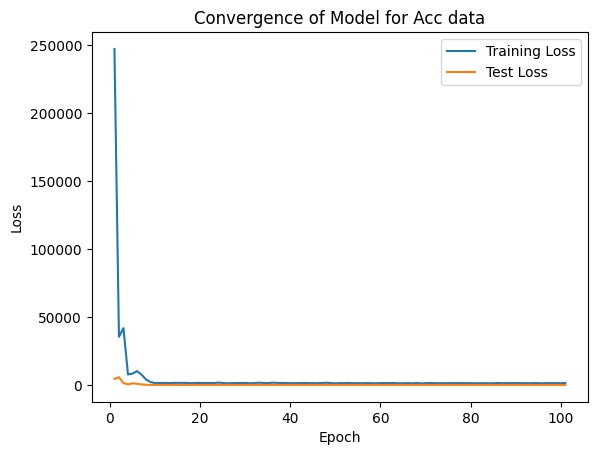

In [ ]:
import matplotlib.pyplot as plt

# Visualize convergence results
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Convergence of Model for Acc data')
plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode

predictions = []  # List to store the predicted outputs

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)  # Move the batch of data to CUDA device
        out = model(data.x.double(), data.edge_index, data.batch)
        predictions.append(out.cpu().detach().numpy())  # Convert the predictions to NumPy array

# Concatenate the predictions from multiple batches
predictions = np.concatenate(predictions)

# Print the predictions
print(predictions)


[54.7908902  42.68042542 41.46369231 46.62099351 43.53139086 46.71744213
 44.86960047 42.71519428 56.23555359 42.44410441 51.97316039 47.2208563
 37.88468131 47.6598499  49.43051608 40.85898411 41.61337731 41.35790309
 41.87858928 50.83126728 55.12354779 46.94001563 47.41400786 47.73594443]


In [ ]:
from sklearn.metrics import r2_score

# Convert the test data batches to a list of Data objects
Test_batches = [
    Data(x=batch.x, edge_index=batch.edge_index, y=batch.y) for batch in test_loader
]

# Convert the predictions to PyTorch tensors
predictions = torch.tensor(predictions)

# Convert the ground truth labels of the test data to a PyTorch tensor
y_true = torch.cat([batch.y for batch in Test_batches])

# Calculate the mean squared error (MSE) loss using PyTorch's function
mse_loss = torch.nn.functional.mse_loss(predictions.view(-1), y_true.view(-1))


print(f"Mean Squared Error (MSE) Loss: {mse_loss:.4f}")

Mean Squared Error (MSE) Loss: 665.1887
